# 1. Perkenalan

Nama : Gusti Ayu Dewi Puspa Kartikasari

Batch : FTDS-012

Dataset : census_adult_income

Objective : Membuat model Classification menggunakan Logistic Regression dan SVM untuk memprediksi income bracket

SQL Querry:

SELECT age, workclass, education, education_num, marital_status, occupation, relationship, race, sex, capital_gain, capital_loss, hours_per_week, native_country, income_bracket
FROM `bigquery-public-data.ml_datasets.census_adult_income`
WHERE workclass != ' ?'
AND hours_per_week <= 100
LIMIT 23940;

# 2. Import Libraries

> Cell pertama pada notebook harus berisi dan hanya berisi semua library yang digunakan dalam project.

In [1]:
#Kolom import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,classification_report,ConfusionMatrixDisplay,confusion_matrix


# 3. Data Loading

> Bagian ini berisi proses penyiapan data sebelum dilakukan eksplorasi data lebih lanjut. Proses Data Loading dapat berupa memberi nama baru untuk setiap kolom, mengecek ukuran dataset, dl

In [2]:
#Data Loading from census_adult_income.csv
df = pd.read_csv(r'h8dsft_P1G2_Gusti_Ayu_Dewi_Puspa_K.csv')
df.head(5)

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
0,39,Private,9th,5,Married-civ-spouse,Other-service,Wife,Black,Female,3411,0,34,United-States,<=50K
1,72,Private,9th,5,Married-civ-spouse,Exec-managerial,Wife,Asian-Pac-Islander,Female,0,0,48,United-States,>50K
2,45,Private,9th,5,Married-civ-spouse,Machine-op-inspct,Wife,White,Female,0,0,40,United-States,>50K
3,31,Private,9th,5,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
4,55,Private,9th,5,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,23,United-States,<=50K


In [3]:
df.tail(5)

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
23935,38,Self-emp-not-inc,HS-grad,9,Never-married,Farming-fishing,Not-in-family,White,Male,0,0,60,United-States,<=50K
23936,68,Private,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,0,10,United-States,>50K
23937,38,Private,HS-grad,9,Divorced,Adm-clerical,Not-in-family,White,Female,0,0,35,United-States,<=50K
23938,38,Private,HS-grad,9,Never-married,Prof-specialty,Not-in-family,White,Male,0,0,40,United-States,<=50K
23939,53,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K


In [4]:
# copy df untuk menjaga data asli
df_copy = df.copy()

In [5]:
# melihat persebaran data df, dan mengetahui masing-masing kolom di dalam df
df.describe()

,age,education_num,capital_gain,capital_loss,hours_per_week
count,23940.000000,23940.000000,23940.000000,23940.000000,23940.000000
mean,38.901128,9.893985,1190.909357,92.319758,40.950710
std,13.141899,2.592545,7889.276354,412.416253,12.158642
min,17.000000,1.000000,0.000000,0.000000,1.000000
25%,29.000000,9.000000,0.000000,0.000000,40.000000
50%,38.000000,9.000000,0.000000,0.000000,40.000000
75%,48.000000,12.000000,0.000000,0.000000,45.000000
max,90.000000,16.000000,99999.000000,4356.000000,99.000000


In [6]:
# melihat null vs non-null data df, untuk mengetahui missing value 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23940 entries, 0 to 23939
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             23940 non-null  int64 
 1   workclass       23940 non-null  object
 2   education       23940 non-null  object
 3   education_num   23940 non-null  int64 
 4   marital_status  23940 non-null  object
 5   occupation      23940 non-null  object
 6   relationship    23940 non-null  object
 7   race            23940 non-null  object
 8   sex             23940 non-null  object
 9   capital_gain    23940 non-null  int64 
 10  capital_loss    23940 non-null  int64 
 11  hours_per_week  23940 non-null  int64 
 12  native_country  23940 non-null  object
 13  income_bracket  23940 non-null  object
dtypes: int64(5), object(9)
memory usage: 2.6+ MB


# 4. Exploratory Data Analysis (EDA)

> Bagian ini berisi eksplorasi data pada dataset diatas dengan menggunakan query, grouping, visualisasi sederhana, heatmap, central tendency dan lain sebagainya.

Target = income_bracket

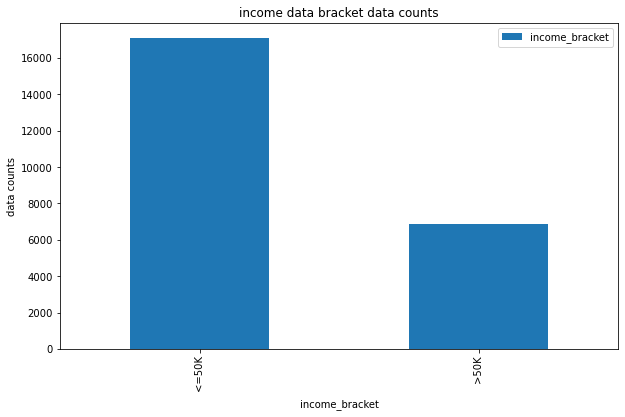

In [7]:
#groupby income bracket
df_copy.groupby(["income_bracket"])[["income_bracket"]].count().plot(kind='bar', figsize=(10, 6))
plt.xlabel('income_bracket') # add to x-label to the plot
plt.ylabel('data counts') # add y-label to the plot
plt.title('income data bracket data counts') # add title to the plot

plt.show()

Dari grafik ini dapat disimpukan bahwa data imbalance antar kedua kategori. Sehingga ada kemungkinan model kurang memperlajari kategori ke 2 dan mengalami kesulitan dalam melakukan predict.

In [8]:
#membuat def perhitungan proportion, sebelum memasukkannya ke grafik
def make_dataplot_proportion(df3,grdf):
    col3 = []
    for i in df3.loc[:,0]:

        try:
            k = pd.Series.item(grdf.loc[i,' <=50K'])
        except KeyError:
            k = 0
        
        try:
            b = pd.Series.item(grdf.loc[i,' >50K'])
        except KeyError:
            b=0

        try:
            col3.append(b/(b+k))
        except ZeroDivisionError:
            col3.append(0)
        
    df3['proportion'] = col3
    pd.DataFrame(df3)

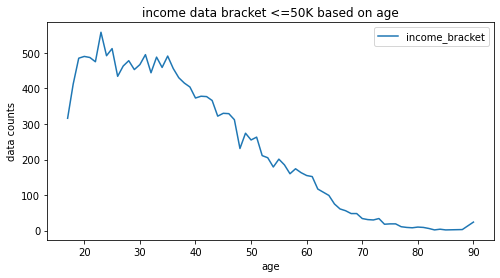

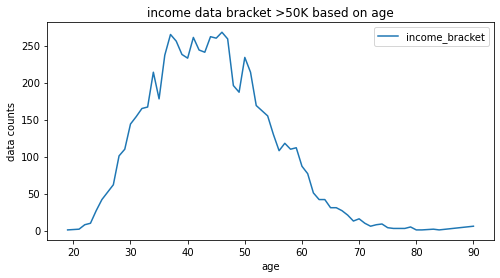

In [9]:
#plot jumlah data berdasarkan age per kategori

df_copy[(df_copy['income_bracket'] == " <=50K")].groupby(["age"])[["income_bracket"]].count().plot(kind='line', figsize=(8, 4))
plt.xlabel('age') # add to x-label to the plot
plt.ylabel('data counts') # add y-label to the plot
plt.title('income data bracket <=50K based on age') # add title to the plot
plt.show()

df_copy[(df_copy['income_bracket'] == " >50K")].groupby(["age"])[["income_bracket"]].count().plot(kind='line', figsize=(8, 4))
plt.xlabel('age') # add to x-label to the plot
plt.ylabel('data counts') # add y-label to the plot
plt.title('income data bracket >50K based on age') # add title to the plot
plt.show()


Kedua grafik diatas kurang tepat menggambarkan situasi income bracket dikarenakan data imbalance, maka hitung menggunakan proporsi, untuk melihat proporsi data >50k dibandingkan total data pada umur tersebut, didapatkanlah:

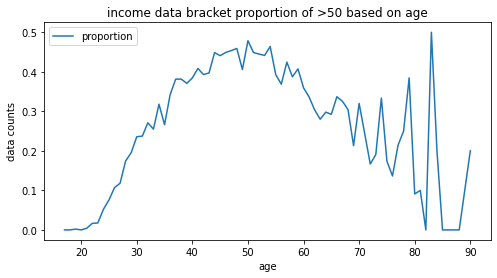

In [10]:
dataunique= pd.DataFrame(df_copy['age'].unique())
gruopeddf = df_copy.groupby(['age','income_bracket'])[["income_bracket"]].count()

make_dataplot_proportion(dataunique,gruopeddf)

dataunique.rename(columns={ 0 : 'age'}, inplace=True)
dataunique=dataunique.sort_values(by='age', ascending=True) 
dataunique.set_index('age', inplace=True)

dataunique.plot(kind='line', figsize=(8, 4))
plt.xlabel('age') # add to x-label to the plot
plt.ylabel('data counts') # add y-label to the plot
plt.title('income data bracket proportion of >50 based on age') # add title to the plot
plt.show()

Dari kedua grafik diatas dapat disimpulkan bahwa age dapat mempengaruhi income bracket terjadi kenaikan proporsi data >50k menandakan setelah umur 25 lebih banyak peserta yang mendapatkan income yang lebih tinggi dibandingkan seluruh data pada umur tersebut.

In [11]:
#membuat def untuk menghitung jumlah data pada masing-masing kategori income bracket dan variable yang dituju
def make_dataplot(df3,grdf):
    col1=[]
    col2=[]
    for i in df3.loc[:,0]:
        try:
            col1.append(pd.Series.item(grdf.loc[i,' <=50K']))
        except KeyError:
            col1.append(0)

        try:
            col2.append(pd.Series.item(grdf.loc[i,' >50K']))
        except KeyError:
            col2.append(0)
    
    df3['<=50K'] = col1
    df3['>50K'] = col2
    pd.DataFrame(df3)

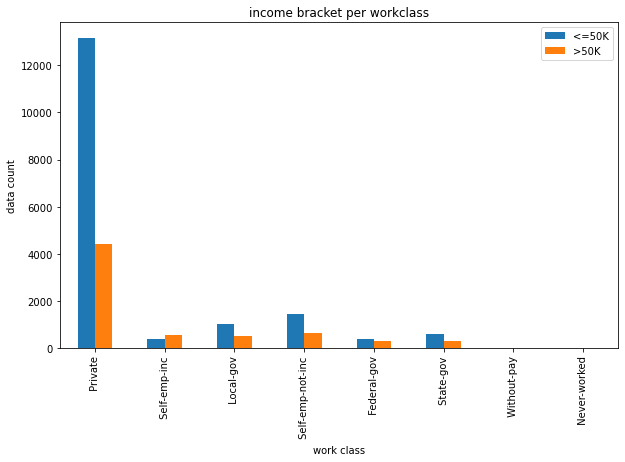

In [12]:
#menghitung dan plot banyaknya data perkategori income bracket pada variabel workclass
dataunique= pd.DataFrame(df_copy['workclass'].unique())
gruopeddf = df_copy.groupby(['workclass','income_bracket'])[["income_bracket"]].count()

df_wc = make_dataplot(dataunique,gruopeddf)

dataunique.rename(columns={ 0 : 'workclass'}, inplace=True)
dataunique.set_index('workclass', inplace=True)

dataunique.plot(kind='bar', figsize=(10, 6))

plt.xlabel('work class') # add to x-label to the plot
plt.ylabel('data count') # add y-label to the plot
plt.title('income bracket per workclass') # add title to the plot

plt.show()

Dari grafik diatas dapat terlihat bahwa self-emp-inc memiliki jumlah data >50K lebih banyak dibandingkan <=50 K serta federal gov memiliki perbandingan <=50K yang hampirsama. Hal ini mendukung bahwa workclass mempengaruhi income bracket.

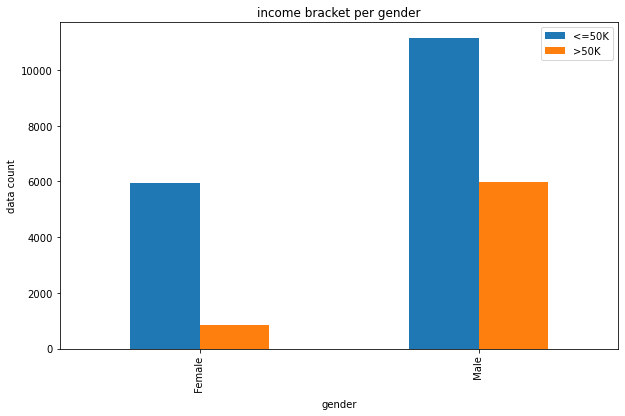

In [13]:
#menghitung dan plot banyaknya data perkategori income bracket pada variabel sex
dataunique= pd.DataFrame(df_copy['sex'].unique())
gruopeddf = df_copy.groupby(['sex','income_bracket'])[["income_bracket"]].count()

make_dataplot(dataunique,gruopeddf)

dataunique.rename(columns={ 0 : 'sex'}, inplace=True)
dataunique.set_index('sex', inplace=True)

dataunique.plot(kind='bar', figsize=(10, 6))

plt.xlabel('gender') # add to x-label to the plot
plt.ylabel('data count') # add y-label to the plot
plt.title('income bracket per gender') # add title to the plot

plt.show()

Terlihat dari proporsi gender diatas,  proporsi female dengan income tinggi lebih sedikit dibandingkan male. Dapat mendukung bahwa sex mempengaruhi income bracket.

In [14]:
#grup berdasarkan 'education','education_num'
df_copy.groupby(['education','education_num'])[["income_bracket"]].count().sort_values(by='education_num', ascending=True) 

,,income_bracket
education,education_num,
Preschool,1,22
1st-4th,2,140
5th-6th,3,263
7th-8th,4,543
9th,5,434
10th,6,796
11th,7,1005
12th,8,374
HS-grad,9,8442


masing-masing kategori education telah diwakili oleh education num. Sehingga apabila feature ini terpilih cukup sertakan salah satu dari 2 kolom ini.

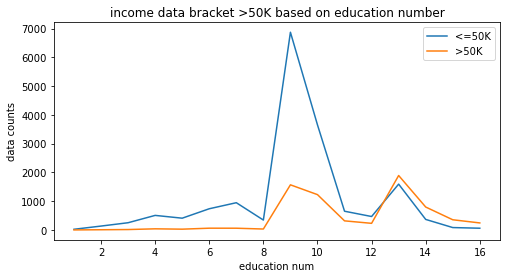

In [15]:
##menghitung dan plot banyaknya data perkategori income bracket pada variabel sex
dataunique= pd.DataFrame(df_copy['education_num'].unique())
gruopeddf = df_copy.groupby(['education_num','income_bracket'])[["income_bracket"]].count()

make_dataplot(dataunique,gruopeddf)

dataunique.rename(columns={ 0 : 'education_num'}, inplace=True)
dataunique = dataunique.sort_values(by='education_num', ascending=True)
dataunique.set_index('education_num', inplace=True)

dataunique.plot(kind='line', figsize=(8, 4))
plt.xlabel('education num') # add to x-label to the plot
plt.ylabel('data counts') # add y-label to the plot
plt.title('income data bracket >50K based on education number') # add title to the plot
plt.show()

Pada educationnum tertentu terjadi peningkatan proporsi peserta sensus yang memiliki income tinggi, yakni pada education num 13 lebih banyak yang memiliki income tinggi. Sehingga dapat diputuskan bahwa education num memiliki peran terhadap income bracket.

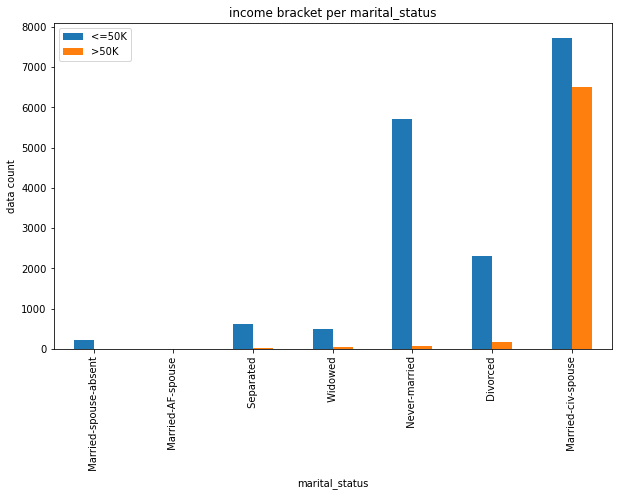

In [16]:
#menghitung dan plot banyaknya data perkategori income bracket pada variabel marital_status
dataunique= pd.DataFrame(df_copy['marital_status'].unique())
gruopeddf = df_copy.groupby(['marital_status','income_bracket'])[["income_bracket"]].count()

df_wc = make_dataplot(dataunique,gruopeddf)

dataunique.rename(columns={ 0 : 'marital_status'}, inplace=True)
dataunique = dataunique.sort_values(by='>50K', ascending=True)
dataunique.set_index('marital_status', inplace=True)

dataunique.plot(kind='bar', figsize=(10, 6))

plt.xlabel('marital_status') # add to x-label to the plot
plt.ylabel('data count') # add y-label to the plot
plt.title('income bracket per marital_status') # add title to the plot

plt.show()

maried civ spouse memiliki proporsi income tinggi lebih banyak dibanding marital status lain, ini mendukung bahwa marital status memiliki korelasi dengan income bracket.

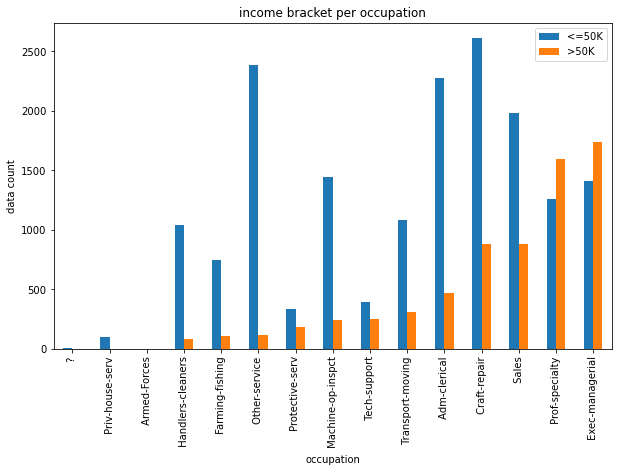

In [17]:
#menghitung dan plot banyaknya data perkategori income bracket pada variabel occupation
dataunique= pd.DataFrame(df_copy['occupation'].unique())
gruopeddf = df_copy.groupby(['occupation','income_bracket'])[["income_bracket"]].count()

df_wc = make_dataplot(dataunique,gruopeddf)

dataunique.rename(columns={ 0 : 'occupation'}, inplace=True)
dataunique = dataunique.sort_values(by='>50K', ascending=True)
dataunique.set_index('occupation', inplace=True)

dataunique.plot(kind='bar', figsize=(10, 6))

plt.xlabel('occupation') # add to x-label to the plot
plt.ylabel('data count') # add y-label to the plot
plt.title('income bracket per occupation') # add title to the plot

plt.show()

exec managerial dan prof specalty memiliki jumlah peserta dengan income tinggi lebih banyak dibanding dengan peserta income rendah.Ini mendukung bahwa occupation dapat mempengaruhi kategori income bracket.

NOTE: terdapat occupation '?' lakukan handling sebagai missing value pada data preprocessing

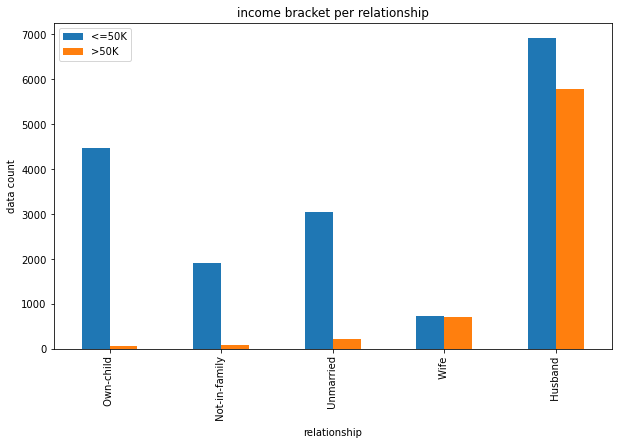

In [18]:
#menghitung dan plot banyaknya data perkategori income bracket pada variabel relationship
dataunique= pd.DataFrame(df_copy['relationship'].unique())
gruopeddf = df_copy.groupby(['relationship','income_bracket'])[["income_bracket"]].count()

df_wc = make_dataplot(dataunique,gruopeddf)

dataunique.rename(columns={ 0 : 'relationship'}, inplace=True)
dataunique = dataunique.sort_values(by='>50K', ascending=True)
dataunique.set_index('relationship', inplace=True)

dataunique.plot(kind='bar', figsize=(10, 6))

plt.xlabel('relationship') # add to x-label to the plot
plt.ylabel('data count') # add y-label to the plot
plt.title('income bracket per relationship') # add title to the plot

plt.show()

Husband dan wife memiliki proporsi income tinggi lebih banyak dibanding relationship lain, ini mendukung bahwa relationship memiliki korelasi dengan income bracket.

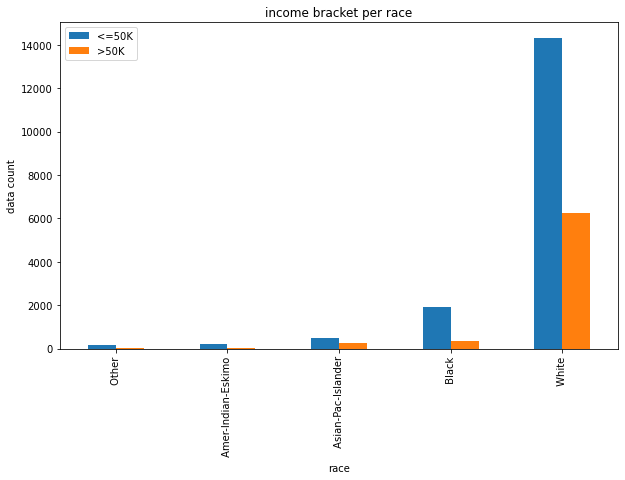

In [19]:
#menghitung dan plot banyaknya data perkategori income bracket pada variabel race
dataunique= pd.DataFrame(df_copy['race'].unique())
gruopeddf = df_copy.groupby(['race','income_bracket'])[["income_bracket"]].count()

df_wc = make_dataplot(dataunique,gruopeddf)

dataunique.rename(columns={ 0 : 'race'}, inplace=True)
dataunique = dataunique.sort_values(by='>50K', ascending=True)
dataunique.set_index('race', inplace=True)

dataunique.plot(kind='bar', figsize=(10, 6))

plt.xlabel('race') # add to x-label to the plot
plt.ylabel('data count') # add y-label to the plot
plt.title('income bracket per race') # add title to the plot

plt.show()

Tidak ada kategori race yang menunjukkan perbedaan signifikan, artinya proporsi income tinggi dengan rendah sama untuk setiap kategori race. Sehingga race memiliki kemungkinnan tidak mempengaruhi income bracket.

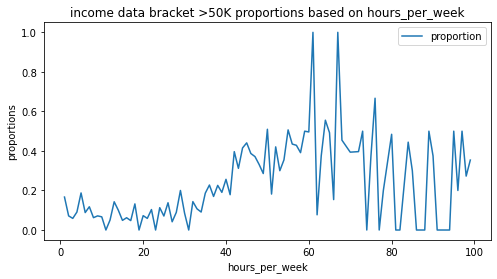

In [20]:
#menghitung dan plot proporsi data perkategori income bracket pada variabel hours_per_week
dataunique= pd.DataFrame(df_copy['hours_per_week'].unique())
gruopeddf = df_copy.groupby(['hours_per_week','income_bracket'])[["income_bracket"]].count()

df_wc = make_dataplot_proportion(dataunique,gruopeddf)

dataunique.rename(columns={ 0 : 'hours_per_week'}, inplace=True)
dataunique = dataunique.sort_values(by='hours_per_week', ascending=True)
dataunique.set_index('hours_per_week', inplace=True)

dataunique.plot(kind='line', figsize=(8, 4))
plt.xlabel('hours_per_week') # add to x-label to the plot
plt.ylabel('proportions') # add y-label to the plot
plt.title('income data bracket >50K proportions based on hours_per_week') # add title to the plot
plt.show()

Peningkatan hours per week juga tidak menunjukkan peningkatan yang signifikan, rata-rata hanya berkisar di 0.1-0.5 kali lipat pendapatan rendah. Sehingga disimpulkan bahwa hours per week tidak terlalu mempengaruhi income bracket.

Text(0.5, 1.0, 'income bracket >50 proportions per native_country')

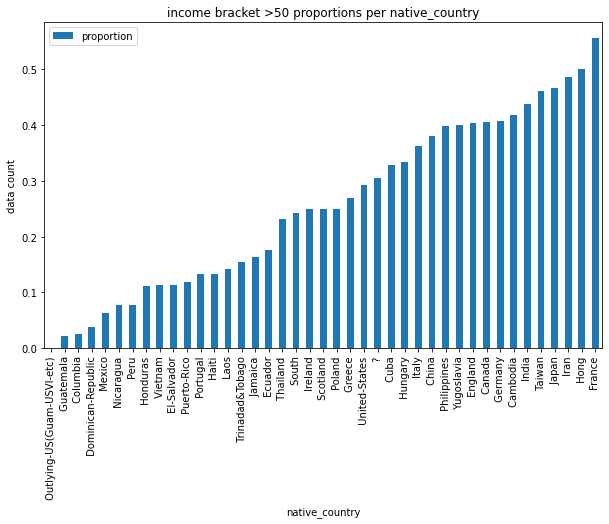

In [21]:
#menghitung dan plot proporsi data perkategori income bracket pada variabel native_country
dataunique= pd.DataFrame(df_copy['native_country'].unique())
gruopeddf = df_copy.groupby(['native_country','income_bracket'])[["income_bracket"]].count()

df_wc = make_dataplot_proportion(dataunique,gruopeddf)

dataunique.rename(columns={ 0 : 'native_country'}, inplace=True)
dataunique = dataunique.sort_values(by='proportion', ascending=True)
dataunique.set_index('native_country', inplace=True)

dataunique.plot(kind='bar', figsize=(10, 6))

plt.xlabel('native_country') # add to x-label to the plot
plt.ylabel('data count') # add y-label to the plot
plt.title('income bracket >50 proportions per native_country') # add title to the plot

# plt.show()

Proporsi income besar di beberapa negara lebih banyak dibanding negara lainnya. Contoh france: memiliki proporsi peserta dengan income besar 0.6 kali otal data peserta pada negara tersebut, sedangkan guatemala tidak sampai 0.1 kali lipat total data pada negara tersebut.
native_country memiliki pengaruh terhadap income bracket.

NOTE: terdapat negara '?' lakukan handling sebagai missing value pada data preprocessing

In [22]:
#Menghitung rata-rata gain mean dan gain loss pada masing-maisng kategorin income bracket
df_big = df_copy[(df_copy['income_bracket'] == " >50K")]
print('gain_mean = ' ,df_big['capital_gain'].mean())
print('loss_mean = ' ,df_big['capital_loss'].mean())
print('gain - loss = ' ,df_big['capital_gain'].mean()-df_big['capital_loss'].mean())
print('*'*50)

df_small = df_copy[(df_copy['income_bracket'] == " <=50K")]
print('gain_mean = ' ,df_small['capital_gain'].mean())
print('loss_mean = ' ,df_small['capital_loss'].mean())
print('gain - loss = ' ,df_small['capital_gain'].mean()-df_small['capital_loss'].mean())


gain_mean =  3780.1483372228704
loss_mean =  197.59524504084013
gain - loss =  3582.5530921820305
**************************************************
gain_mean =  151.81883633809412
loss_mean =  50.07152891594475
gain - loss =  101.74730742214936


gain - loss pada income bracket tinggi lebih tinggi dibanding income bracket rendah. Maka dapat disimpulkan bahwa peserta dengan income tinggi memiliki keuntungan capital lebih besar, maka kedua kolom ini memiliki potensi mempengaruhi income bracket. Namun jika dilihat data yang tersedia, tidak ada data dimana kedua kolom ini sama-sama terisi, maka masukkan kedua kolom apabila kolom ini diambil sebagai feature.

# 5. Data Preprocessing

> Bagian ini berisi proses penyiapan data untuk proses pelatihan model, seperti pembagian data menjadi train-dev-test, transformasi data (normalisasi, encoding, dll.), dan proses-proses lain yang dibutuhkan.

## Get Data for Model Inference

In [23]:
#Get data inference sebanyak 30 row sample dan lock randomize.
df_inf = df_copy.sample(30, random_state = 15)
df_inf.shape

(30, 14)

In [24]:
# Hapus data yang dipakai oleh data inference dari df
df_trts = df_copy.drop(df_inf.index)

# Cek ukuran dataset untuk train dan test, telah berkurang 30 row dari 23940:
df_trts.shape

(23910, 14)

In [25]:
# Reset index dari kedua dataframe inference dan data untuk train & test
df_inf.reset_index(drop = True, inplace=True)
df_trts.reset_index(drop = True, inplace=True)
df_inf.head()

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
0,27,Local-gov,HS-grad,9,Never-married,Prof-specialty,Own-child,Black,Female,0,0,40,United-States,<=50K
1,19,Private,7th-8th,4,Never-married,Craft-repair,Own-child,White,Male,0,1602,32,United-States,<=50K
2,24,Local-gov,HS-grad,9,Never-married,Protective-serv,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,25,Private,HS-grad,9,Married-civ-spouse,Other-service,Wife,White,Female,0,0,25,Mexico,<=50K
4,36,Private,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,45,United-States,<=50K


## Splitting Dataset, y-X and train-test

In [26]:
#Splitting dataset X adalah feature dan y adalah target
X = df_trts.drop('income_bracket', axis = 1)
y = df_trts['income_bracket']

In [27]:
#Splitting dataset menjadi 80% untuk train dan 20% untuk test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15)

In [28]:
#Cek ukuran dataset train dan test untuk memastikan proporsi
print('Train set size: ', X_train.shape)
print('Test set size: ', X_test.shape)

Train set size:  (19128, 13)
Test set size:  (4782, 13)


## Feature Selection

Feature Selection dilakukan sebelum data preprocessing untuk mempersempit cakupan preprocessing data sehingga dapat mengurangi waktu pengolahan data dan menghindari mengolah data yang pada akhirnya tidak terpakai.

In [29]:
#Display X_train to see the features
X_train.head()

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country
15201,27,Private,HS-grad,9,Never-married,Protective-serv,Own-child,White,Male,0,0,40,Japan
14038,39,Federal-gov,Some-college,10,Married-civ-spouse,Adm-clerical,Husband,Black,Male,0,0,40,United-States
11107,38,Local-gov,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,56,United-States
23357,25,Private,HS-grad,9,Divorced,Other-service,Not-in-family,White,Male,0,0,40,Mexico
4326,33,Private,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States


In [30]:
# menganalisa feature lain yang dicurigai memiliki korelasi dengan price dengan menentukan nilai beberapa feature yang terpilih dan melihat perbedaannya 
df_analyze = df_copy[
    (df_copy['age'] <= 50) &
    (df_copy['workclass'] == ' Private') &
    (df_copy['education'] == ' HS-grad') &
    (df_copy['sex'] == ' Female') &
    (df_copy['native_country'] == ' United-States') &
    (df_copy['marital_status'] == ' Never-married') &
    #(df_copy['income_bracket'] == ' >50K') &
    (df_copy['hours_per_week'] <50) 
]
df_analyze.groupby(['race','income_bracket'])[["income_bracket"]].count()

income_bracket
race                income_bracket                
 Amer-Indian-Eskimo  <=50K                       7
 Asian-Pac-Islander  <=50K                       9
 Black               <=50K                     137
 Other               <=50K                       3
 White               <=50K                     517
                     >50K                        3

Tabel diatas digunakan untuk memastikan kembali bahwa race tidak memiliki korelasi yang tinggi dengan income bracket. Namun pada kolom terakhir, tidak ada indikasi bahwa race tertentu memiliki proporsi peserta sensus dengan pendapatan tinggi lebih banyak. Race diputuskan tidak dipilih sebagai feature. 

In [31]:
# menganalisa feature lain yang dicurigai memiliki korelasi dengan price dengan menentukan nilai beberapa feature yang terpilih dan melihat perbedaannya 
df_analyze = df_copy[
    (df_copy['age'] <= 50) &
    (df_copy['workclass'] == ' Private') &
    (df_copy['education'] == ' HS-grad') &
    (df_copy['race'] == ' White') &
    (df_copy['native_country'] == ' United-States') &
    (df_copy['marital_status'] == ' Married-civ-spouse') &
    #(df_copy['income_bracket'] == ' >50K') &
    (df_copy['hours_per_week'] <50) 
]
df_analyze.groupby(['sex','income_bracket'])[["income_bracket"]].count()

income_bracket
sex     income_bracket                
 Female  <=50K                     134
         >50K                       83
 Male    <=50K                    1065
         >50K                      390

Tabel diatas digunakan untuk memastikan kembali bahwa gender memiliki korelasi yang tinggi dengan income bracket. Pada kolom terakhir, terlihat bahwa male memiliki proporsi peserta sensus dengan pendapatan tinggi lebih banyak. gender diputuskan sebagai feature yang mempengaruhi income_bracket.

In [32]:
#Keep only featurs that selected
#Berdasarkan hasil EDA beberapa features yang tidak terlihat memiliki pengaruh terhadap income bracket yaitu: race, dan hours per week. Sedangkan education di exclude karena masing-masing nilainya telah terwakilkan oleh education_num

X_train_fs = X_train.loc[:,['age','workclass', 'education_num','marital_status','occupation','relationship','sex','capital_gain','capital_loss','native_country']]
X_test_fs = X_test.loc[:,['age','workclass', 'education_num','marital_status','occupation','relationship','sex','capital_gain','capital_loss','native_country']]
X_test_fs.head(3)

,age,workclass,education_num,marital_status,occupation,relationship,sex,capital_gain,capital_loss,native_country
877,57,Private,13,Married-civ-spouse,Sales,Wife,Female,0,0,United-States
2777,61,Private,4,Married-civ-spouse,Farming-fishing,Husband,Male,0,0,United-States
21641,36,Federal-gov,10,Divorced,Exec-managerial,Unmarried,Female,0,0,United-States


## Missing value handling

Pada saat EDA ditemukan bahwa terdapat 2 kolom yang memiliki nilai '?' yakni occupation dan native_country
'?' akan dianggap sebagai missing value

In [33]:
#Cari nilai '?' pada kedua kolom. Dan simpan sebagai variable untuk drop
MV_trainocc = X_train_fs[
    (X_train_fs['occupation'] == ' ?')
]

MV_trainocc.shape

(7, 10)

In [34]:
#Cari nilai '?' pada kedua kolom. Dan simpan sebagai variable untuk drop
MV_trainNC = X_train_fs[
    (X_train_fs['native_country'] == ' ?')
]
MV_trainNC.shape

(333, 10)

Untuk kedua kolom ini: occupation memiliki nilai 7 dari 19128 (0.03% data) dan native_country memiliki nilai 333 dari 19128 (1.7% data). Karena jumlahnya minim maka diputuskan untuk drop row yang memiliki data '?'

In [35]:
#drop row dengan data '?'
X_train_MV = X_train_fs.copy()
X_train_MV.drop(index = MV_trainocc.index , inplace = True)
X_train_MV.drop(index = MV_trainNC.index , inplace = True)

y_train_MV = y_train.copy()
y_train_MV.drop(index = MV_trainocc.index , inplace = True)
y_train_MV.drop(index = MV_trainNC.index , inplace = True)

In [36]:
#cek data apakah masih ada '?'
X_train_MV[
    (X_train_MV['occupation'] == ' ?')|
    (X_train_MV['native_country'] == ' ?')
]

,age,workclass,education_num,marital_status,occupation,relationship,sex,capital_gain,capital_loss,native_country


'?' pada test telah berhasil di trimming

Lakukan juga pada test set

In [37]:
#Cari nilai '?' pada kedua kolom. Dan simpan sebagai variable untuk drop
MV_testocc = X_test_fs[(X_test_fs['occupation'] == ' ?')]

MV_testNC = X_test_fs[(X_test_fs['native_country'] == ' ?')]

In [38]:
#drop row dengan data '?'
X_test_MV = X_test_fs.copy()
X_test_MV.drop(index = MV_testocc.index , inplace = True)
X_test_MV.drop(index = MV_testNC.index , inplace = True)

y_test_MV = y_test.copy()
y_test_MV.drop(index = MV_testocc.index , inplace = True)
y_test_MV.drop(index = MV_testNC.index , inplace = True)

In [39]:
#cek data apakah masih ada '?'
X_test_MV[(X_test_MV['occupation'] == ' ?')|(X_test_MV['native_country'] == ' ?')]

,age,workclass,education_num,marital_status,occupation,relationship,sex,capital_gain,capital_loss,native_country


'?' pada test telah berhasil di trimming

In [40]:
# Looking missing value in X_train
X_train_MV.isnull().sum().sum()

0

In [41]:
# Looking missing value in X_test
X_test_MV.isnull().sum().sum()

0

In [42]:
# Looking missing value in y_test
y_test_MV.isnull().sum().sum()

0

In [43]:
# Looking missing value in y_train
y_train_MV.isnull().sum().sum()

0

Tidak terdapat missing value pada kedua dataset selain '?' yang telah di drop. Proceed ke outlier handling.

## Split between Numerical Columns and Categorical Columns

Data Splitting antara kolom kategori dan numerical dilakukan sebelum outlier untuk memudahkan outlier handling, baik dari sisi grafik dan pengihitungan outlier.

In [44]:
X_train_MV.head(3)

,age,workclass,education_num,marital_status,occupation,relationship,sex,capital_gain,capital_loss,native_country
15201,27,Private,9,Never-married,Protective-serv,Own-child,Male,0,0,Japan
14038,39,Federal-gov,10,Married-civ-spouse,Adm-clerical,Husband,Male,0,0,United-States
11107,38,Local-gov,12,Married-civ-spouse,Protective-serv,Husband,Male,0,0,United-States


In [45]:
#Memilih feature numerical dan categorical

num_col = ['age']
cat_col = ['workclass','marital_status','occupation','relationship','sex','native_country','capital_gain', 'capital_loss','education_num']

In [46]:
#feature selection num dan category
print('Numerical Columns : ', num_col)
print('Categorical Columns : ', cat_col)

Numerical Columns :  ['age']
Categorical Columns :  ['workclass', 'marital_status', 'occupation', 'relationship', 'sex', 'native_country', 'capital_gain', 'capital_loss', 'education_num']


In [47]:
# Split data set sesuai dengan categorical dan numerical
X_train_num = X_train_MV[num_col]
X_train_cat = X_train_MV[cat_col]

X_test_num = X_test_MV[num_col]
X_test_cat = X_test_MV[cat_col]

In [48]:
#melihat kolom train num
X_train_num.head(3)

,age
15201,27
14038,39
11107,38


In [49]:
#melihat kolom train cat
X_train_cat.head(3)

,workclass,marital_status,occupation,relationship,sex,native_country,capital_gain,capital_loss,education_num
15201,Private,Never-married,Protective-serv,Own-child,Male,Japan,0,0,9
14038,Federal-gov,Married-civ-spouse,Adm-clerical,Husband,Male,United-States,0,0,10
11107,Local-gov,Married-civ-spouse,Protective-serv,Husband,Male,United-States,0,0,12


## Outliers handling

In [50]:
# Membuat def fungsi untuk membuat histogram dan boxplot bagi numerical X_train 
def hist_boxplot(df, variable):
    # Define figure size
    plt.figure(figsize=(10, 3))

    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(df[variable], bins=30)
    plt.title('Histogram')

    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')

    plt.show()

    print('skewness:', df[variable].skew())
    if (df[variable].skew() >= -0.5 ) | (df[variable].skew() <= 0.5 ) :
      print('the distribution is normal')
    else:
      print('the distribution is skewed')

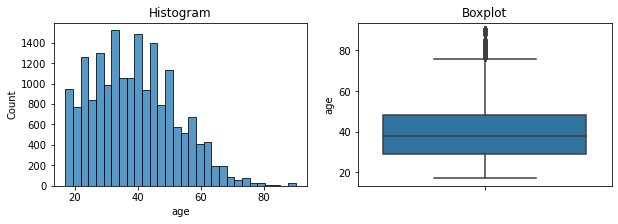

skewness: 0.45499597246969087
the distribution is normal


In [51]:
#munculkan histogram dan boxplot bagi feature di X_Train_num
hist_boxplot(X_train_num, 'age')

age features memiliki normal distribution, sehingga metode yang digunakan untuk handling outlier adalah gaussian. Age dianggap memiliki outlier dikarenakan akan sangat susah bagi peserta sensus diatas umur 80 masih memiliki penghasilan (sudah pensiun) sehingga ini dianggap bukan outlier natural

### gausian std dev

In [52]:
# Function to find upper and lower boundaries for normally distributed variables
# Calculate the boundaries outside which sit the outliers for a Gaussian distribution

def find_normal_boundaries(df, variable):
    upper_boundary = df[variable].mean() + 3 * df[variable].std()
    lower_boundary = df[variable].mean() - 3 * df[variable].std()

    return upper_boundary, lower_boundary

In [53]:
# calculate boundaries for age
upper_boundary, lower_boundary = find_normal_boundaries(X_train_num, 'age')
upper_boundary, lower_boundary

(78.43403474300578, -0.6513010832229398)

### filter outlier

In [54]:
# Fungsi untuk memfilter outlier (mencari outlier)
def find_outliers(df,variable,upper,lower):
  return df[
            (df[variable] > upper) |
            (df[variable] < lower)
            ]

In [55]:
#mencari outliers age, menyimpannya ke dalam variable agar indexnya dapat digunakan untuk drop index pada category dan y(target)
age_train_outliers = find_outliers(X_train_num,'age', upper_boundary, lower_boundary)
age_train_outliers.shape

(67, 1)

In [56]:
#drop row train set outliers
X_train_numO = X_train_num.copy()
X_train_numO.drop(index = age_train_outliers.index , inplace = True)

X_train_catO = X_train_cat.copy()
X_train_catO.drop(index = age_train_outliers.index , inplace = True)

y_train_O = y_train_MV.copy()
y_train_O.drop(index = age_train_outliers.index , inplace = True)

In [57]:
#mencari outliers
age_test_outliers = find_outliers(X_test_num,'age', upper_boundary, lower_boundary)
age_test_outliers.shape

(14, 1)

Karena data outlier jumlahnya minim, hanya 14 data maka diputuskan untuk trimming

In [58]:
#lakukan outlierhandling pafa test juga
X_test_numO = X_test_num.copy()
X_test_numO.drop(index = age_test_outliers.index , inplace = True)

X_test_catO = X_test_cat.copy()
X_test_catO.drop(index = age_test_outliers.index , inplace = True)

y_test_O = y_test_MV.copy()
y_test_O.drop(index = age_test_outliers.index , inplace = True)

## Cardinality


Lakukan cardinality apabila diperlukan pada category dataset

In [59]:
for i in X_test_catO.columns:
    print(i," : ", len(X_train_MV[i].unique()))

workclass  :  7
marital_status  :  7
occupation  :  14
relationship  :  5
sex  :  2
native_country  :  40
capital_gain  :  108
capital_loss  :  82
education_num  :  16


In [60]:
for i in X_train_catO.columns:
    print(i," : ", len(X_train_catO[i].unique()))


workclass  :  7
marital_status  :  7
occupation  :  14
relationship  :  5
sex  :  2
native_country  :  40
capital_gain  :  108
capital_loss  :  81
education_num  :  16


In [61]:
for i in X_train_catO.columns:
    print(i," : ", len(X_test_catO[i].unique()))

workclass  :  7
marital_status  :  7
occupation  :  14
relationship  :  5
sex  :  2
native_country  :  39
capital_gain  :  69
capital_loss  :  52
education_num  :  16


High cardinality in capital_gain and capital_loss sehingga test hanya memiliki beberapa kategori train. oleh karena itu diputuskan membagi setiap angka dengan 10.000 and rounddown. Membuat class baru yang lebih sederhana.

In [62]:
#membentuk class lain yang lebih sederhana
X_train_catO['gain_reduced'] = np.floor(X_train_catO['capital_gain']/10000)
X_test_catO['gain_reduced'] = np.floor(X_test_catO['capital_gain']/10000)

X_train_catO['loss_reduced'] = np.floor(X_train_catO['capital_loss']/10000)
X_test_catO['loss_reduced'] = np.floor(X_test_catO['capital_loss']/10000)

In [63]:
#cek kategori setelah convert
for i in ('gain_reduced','loss_reduced'):
    print(i," train : ", len(X_train_catO[i].unique()))

for i in ('gain_reduced','loss_reduced'):
    print(i," test : ", len(X_test_catO[i].unique()))

gain_reduced  train :  6
loss_reduced  train :  1
gain_reduced  test :  5
loss_reduced  test :  1


In [64]:
#Drop kolom 'capital_gain' dan 'capital_loss'
X_train_catO.drop(['capital_gain','capital_loss'], axis=1, inplace=True)
X_test_catO.drop(['capital_gain','capital_loss'], axis=1, inplace=True)

In [65]:
#hasil cardinality
X_train_catO.head(3)

,workclass,marital_status,occupation,relationship,sex,native_country,education_num,gain_reduced,loss_reduced
15201,Private,Never-married,Protective-serv,Own-child,Male,Japan,9,0.0,0.0
14038,Federal-gov,Married-civ-spouse,Adm-clerical,Husband,Male,United-States,10,0.0,0.0
11107,Local-gov,Married-civ-spouse,Protective-serv,Husband,Male,United-States,12,0.0,0.0


## Feature Scaling

### normal

In [66]:
# deklarasikan scaler
scaler = StandardScaler()

# scale data training
X_train_scaled = scaler.fit_transform(X_train_numO)

# scale data test
X_test_scaled = scaler.transform(X_test_numO)

In [67]:
#scalling X_train_num
X_train_scaled

array([[-0.90806442],
       [ 0.02104276],
       [-0.05638284],
       ...,
       [-0.59836202],
       [ 0.71787313],
       [-0.44351083]])

Scaling telah dilakukan

## Feature Encoding

In [68]:
# Show category dataset
X_train_catO.head(3)

,workclass,marital_status,occupation,relationship,sex,native_country,education_num,gain_reduced,loss_reduced
15201,Private,Never-married,Protective-serv,Own-child,Male,Japan,9,0.0,0.0
14038,Federal-gov,Married-civ-spouse,Adm-clerical,Husband,Male,United-States,10,0.0,0.0
11107,Local-gov,Married-civ-spouse,Protective-serv,Husband,Male,United-States,12,0.0,0.0


In [69]:
#Split data train menjadi nominal dan none (tidak dilakukan encoding karena telah encoded) category
X_train_catO_nom = X_train_catO[['workclass','marital_status','occupation','relationship','sex','native_country']]
X_train_catO_none = X_train_catO[['education_num','gain_reduced','loss_reduced']]

#Split data test menjadi nominal dan none (tidak dilakukan encoding karena telah encoded) category
X_test_catO_nom = X_test_catO[['workclass','marital_status','occupation','relationship','sex','native_country']]
X_test_catO_none = X_test_catO[['education_num','gain_reduced','loss_reduced']]

### nominal encoding

In [70]:
#fit one hot encoder bagi nominal category
encoder = OneHotEncoder()
encoder.fit(pd.DataFrame(X_train_catO_nom))

OneHotEncoder()

In [71]:
#transform dataset nominal train dan test menggunakan onehot encoder
X_train_cat_nom_enc = encoder.transform(pd.DataFrame(X_train_catO_nom)).toarray()
X_test_cat_nom_enc = encoder.transform(pd.DataFrame(X_test_catO_nom)).toarray()

In [72]:
#Hasil encoding
X_train_cat_nom_enc

array([[0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 1., ..., 1., 0., 0.],
       [0., 0., 1., ..., 1., 0., 0.],
       [0., 0., 1., ..., 1., 0., 0.]])

Encoding train telah berhasil dilakukan

Encoding target perlu dilakukan dikarenakan target merupakan label.

In [73]:
#Encoding target
labelencoder = preprocessing.LabelEncoder()
labelencoder.fit(y_train_O)

LabelEncoder()

In [74]:
#classes dari label encoder
labelencoder.classes_

array([' <=50K', ' >50K'], dtype=object)

In [75]:
#transform kedua y target
y_train_enc = labelencoder.transform(y_train_O)
y_test_enc = labelencoder.transform(y_test_O)

In [76]:
#hasil encoding
y_test_enc

array([0, 0, 1, ..., 0, 0, 1])

## Concate between Numerical Columns and Categorical Columns

In [77]:
#Satukan keempat dataset train dan test yang telah melewati proses scaling dan encoding (X_train_num_sc, X_train_cat_nom_enc, X_train_cat_ordinal_enc,X_train_cat_none)
X_train_fin = np.concatenate([X_train_scaled, X_train_cat_nom_enc, X_train_catO_none], axis=1)
X_test_fin = np.concatenate([X_test_scaled, X_test_cat_nom_enc, X_test_catO_none], axis=1)
X_train_fin

array([[-0.90806442,  0.        ,  0.        , ...,  9.        ,
         0.        ,  0.        ],
       [ 0.02104276,  1.        ,  0.        , ..., 10.        ,
         0.        ,  0.        ],
       [-0.05638284,  0.        ,  1.        , ..., 12.        ,
         0.        ,  0.        ],
       ...,
       [-0.59836202,  0.        ,  0.        , ..., 11.        ,
         0.        ,  0.        ],
       [ 0.71787313,  0.        ,  0.        , ...,  9.        ,
         0.        ,  0.        ],
       [-0.44351083,  0.        ,  0.        , ..., 14.        ,
         0.        ,  0.        ]])

# 6. Model definition

Notes :

Algoritma yang akan dipakai adalah Logistic Regression dan Support Vektor Classifier.

Dengan metrics yang akan dipakai untuk mengevaluasi adalah accuracy_score,classification_report,ConfusionMatrixDisplay,confusion_matrix untuk mengetahui recall, precision, nilai akurasi, dan melihat banyaknya data yang salah predict.

In [78]:
#Training using Logistic regression
log_model = LogisticRegression()

In [79]:
#Training using SVC 
SVC_model = SVC(kernel='poly',C=1,degree=2)

kernel poly dipilih karena mencoba preprocessing polynomial setelah logistic regression.

# 7. Model Training

In [80]:
# Train model menggunakan dataset X dan y train
log_model.fit(X_train_fin, y_train_enc)

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

In [81]:
# Train model menggunakan dataset X dan y train
SVC_model.fit(X_train_fin, y_train_enc)

SVC(C=1, degree=2, kernel='poly')

# 8. Model Evaluation

### LogReg

In [82]:
#Lakukan predict bagi test dan train
y_pred_train = log_model.predict(X_train_fin)
y_pred_test = log_model.predict(X_test_fin)

In [83]:
#print accuracy score
print('accuracy score train : ',accuracy_score(y_train_enc,y_pred_train))
print('accuracy score test : ',accuracy_score(y_test_enc,y_pred_test))

accuracy score train :  0.8184391859409219
accuracy score test :  0.8190557573168127


Accuracy score bagus, tidak jauh berbeda juga, namun hal ini tidak bisa menjadi patokan karena data imbalance. Lanjutkan ke classification report

In [84]:
#print classification report
print('-----------train-------------')
print(classification_report(y_train_enc,y_pred_train))
print('-----------test-------------')
print(classification_report(y_test_enc,y_pred_test))

-----------train-------------
              precision    recall  f1-score   support

           0       0.85      0.90      0.88     13296
           1       0.72      0.62      0.66      5425

    accuracy                           0.82     18721
   macro avg       0.78      0.76      0.77     18721
weighted avg       0.81      0.82      0.81     18721

-----------test-------------
              precision    recall  f1-score   support

           0       0.86      0.90      0.88      3396
           1       0.69      0.61      0.65      1285

    accuracy                           0.82      4681
   macro avg       0.78      0.75      0.76      4681
weighted avg       0.81      0.82      0.82      4681



pada classification report yang dilihat adalah baris '1' yang menandakan 1 = 1. dimana precision 0.72 untuk train dan 0.69 untuk test. Artinya model robust, namun ada beberapa hal yang perlu dilakukan untuk improvement. Seperti pengurangan atau penambahan feature, atau mencoba dengan model lain.

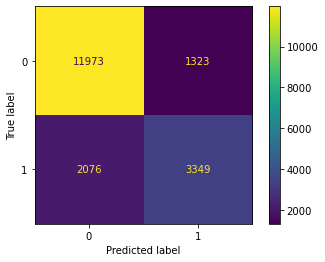

In [85]:
cm = confusion_matrix(y_train_enc,y_pred_train, labels=log_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=log_model.classes_)

disp.plot()
plt.show()

Terjadi kelemahan prediksi pada kategori 1 yang dikarenakan data imbalance dengan data terkecil pada kategori ini. Sehingga model belum banyak belajar mengenai kategori ini dan meningkatkan misspredict.

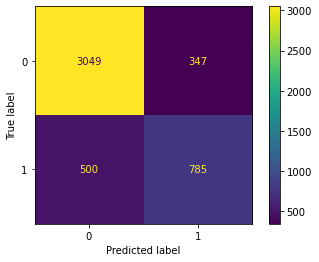

In [86]:
cm = confusion_matrix(y_test_enc,y_pred_test, labels=log_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=log_model.classes_)

disp.plot()
plt.show()

Terjadi kelemahan prediksi pada kategori 1 yang dikarenakan data imbalance dengan data terkecil pada kategori ini. Sehingga model belum banyak belajar mengenai kategori ini dan meningkatkan misspredict.

### SVC

In [87]:
#Lakukan predict bagi test dan train
y_pred_train2 = SVC_model.predict(X_train_fin)
y_pred_test2 = SVC_model.predict(X_test_fin)

In [88]:
#print accuracy score
print('accuracy score train : ',accuracy_score(y_train_enc,y_pred_train2))
print('accuracy score test : ',accuracy_score(y_test_enc,y_pred_test2))

accuracy score train :  0.8159820522407991
accuracy score test :  0.8169194616534928


Accuracy score bagus, tidak jauh berbeda juga, namun hal ini tidak bisa menjadi patokan karena data imbalance. Lanjutkan ke classification report. Namun jika dilihat perbandingan dengan log reg, lebih bagus menggunakan log reg karena perbedaan train-test lebih kecil

In [89]:
#print classification report
print('-----------train-------------')
print(classification_report(y_train_enc,y_pred_train2))
print('-----------test-------------')
print(classification_report(y_test_enc,y_pred_test2))

-----------train-------------
              precision    recall  f1-score   support

           0       0.85      0.91      0.87     13296
           1       0.72      0.60      0.65      5425

    accuracy                           0.82     18721
   macro avg       0.78      0.75      0.76     18721
weighted avg       0.81      0.82      0.81     18721

-----------test-------------
              precision    recall  f1-score   support

           0       0.85      0.91      0.88      3396
           1       0.70      0.58      0.63      1285

    accuracy                           0.82      4681
   macro avg       0.78      0.74      0.76      4681
weighted avg       0.81      0.82      0.81      4681



pada classification report yang dilihat adalah baris '1' yang menandakan 1 = 1. dimana precision 0.72 untuk train dan 0.70 untuk test. Secara precission lebih baik namun secara recall lebih tidak bagus dbndg model logreg. Artinya model robust, namun ada beberapa hal yang perlu dilakukan untuk improvement. Seperti pengurangan atau penambahan feature, atau mencoba dengan model/parameter lain.

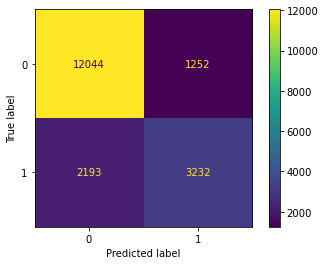

In [90]:
cm = confusion_matrix(y_train_enc,y_pred_train2, labels=log_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=log_model.classes_)

disp.plot()
plt.show()

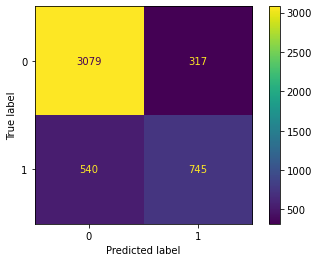

In [91]:
cm = confusion_matrix(y_test_enc,y_pred_test2, labels=log_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=log_model.classes_)

disp.plot()
plt.show()

Masih terjadi kelemahan prediksi pada kategori 1 yang dikarenakan data imbalance dengan data terkecil pada kategori ini. Sehingga model belum banyak belajar mengenai kategori ini dan meningkatkan misspredict.

# 9. Model Inference

Lakukan test terhadap data inference (data yang akan ada di masa depan)

In [92]:
#munculkan data set inference
df_inf.head(5)

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
0,27,Local-gov,HS-grad,9,Never-married,Prof-specialty,Own-child,Black,Female,0,0,40,United-States,<=50K
1,19,Private,7th-8th,4,Never-married,Craft-repair,Own-child,White,Male,0,1602,32,United-States,<=50K
2,24,Local-gov,HS-grad,9,Never-married,Protective-serv,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,25,Private,HS-grad,9,Married-civ-spouse,Other-service,Wife,White,Female,0,0,25,Mexico,<=50K
4,36,Private,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,45,United-States,<=50K


In [93]:
#Lihat missing value pada data inference
df_inf.isnull().sum()

age               0
workclass         0
education         0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
income_bracket    0
dtype: int64

In [94]:
#? pada occupation, tidak ada = tidak perlu handling
df_infocc = df_inf[
    (df_inf['occupation'] == ' ?')
]
df_infocc.shape

(0, 14)

In [95]:
#? pada native_country, ada = perlu handling
df_infocc = df_inf[
    (df_inf['native_country'] == ' ?')
]
df_infocc.shape

(1, 14)

In [96]:
#drop data '?'
df_inf_MV = df_inf.copy()
df_inf_MV.drop(index = df_infocc.index , inplace = True)
df_inf_MV.reset_index(drop = True, inplace=True)

In [97]:
#cek data '?'
df_inf_MV[
    (df_inf_MV['native_country'] == ' ?')
]

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_bracket


In [98]:
#Split data inference berdasarkan kolom numeric dan categoric
df_inf_num = df_inf_MV[num_col]
df_inf_cat = df_inf_MV[cat_col]

Tidak ada handling outliers pada inference data

In [99]:
#Handling outliers: tidak ada data distance yang merupakan outliers
age_inf_outliers = find_outliers(df_inf_num,'age', upper_boundary, lower_boundary)
age_inf_outliers

,age
11,90


In [100]:
#lakukan cardinality
df_inf_cat['gain_reduced'] = np.floor(df_inf_cat['capital_gain']/10000)
df_inf_cat['loss_reduced'] = np.floor(df_inf_cat['capital_loss']/10000)


C:\Users\Agung\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Agung\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [101]:
#Drop kolom 'capital_gain' dan 'capital_loss'
df_inf_cat.drop(['capital_gain','capital_loss'], axis=1, inplace=True)

df_inf_cat.head(3)

c:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,workclass,marital_status,occupation,relationship,sex,native_country,education_num,gain_reduced,loss_reduced
0,Local-gov,Never-married,Prof-specialty,Own-child,Female,United-States,9,0.0,0.0
1,Private,Never-married,Craft-repair,Own-child,Male,United-States,4,0.0,0.0
2,Local-gov,Never-married,Protective-serv,Not-in-family,Male,United-States,9,0.0,0.0


In [102]:
# scale data test
X_inf_scaled = scaler.transform(df_inf_num)

In [103]:
#Split data train menjadi nominal dan none (tidak dilakukan encoding karena telah encoded) category
df_inv_cat_nom = df_inf_cat[['workclass','marital_status','occupation','relationship','sex','native_country']]
df_inv_cat_none = df_inf_cat[['education_num','gain_reduced','loss_reduced']]

In [104]:
df_inv_cat_none.head(3)

,education_num,gain_reduced,loss_reduced
0,9,0.0,0.0
1,4,0.0,0.0
2,9,0.0,0.0


In [105]:
#transform dataset nominal train dan test menggunakan onehot encoder
df_inv_cat_nom_enc = encoder.transform(df_inv_cat_nom).toarray()

In [106]:
#Satukan keempat dataset train dan test yang telah melewati proses scaling dan encoding (X_train_num_sc, X_train_cat_nom_enc, X_train_cat_ordinal_enc,X_train_cat_none)
X_inf_fin = np.concatenate([X_inf_scaled, df_inv_cat_nom_enc, df_inv_cat_none], axis=1)

### Log Reg

In [107]:
#lakukan predict pada data
y_pred_inf_LR = log_model.predict(X_inf_fin)
y_pred_inf_LR

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0])

In [108]:
#convert kembali nama label hasil prediksi
y_pred_inf_LR = labelencoder.inverse_transform(y_pred_inf_LR)

In [109]:
# Create Dataframe of Rating's Prediction
y_pred_inf_inf_LR= pd.DataFrame(y_pred_inf_LR , columns=['Income_Bracket_Predicted'])

# Concate between Inference-Set and Rating's Prediction
df_inf_LR = pd.concat([df_inf_MV, y_pred_inf_inf_LR ], axis=1)
df_inf_LR.head(3)

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_bracket,Income_Bracket_Predicted
0,27,Local-gov,HS-grad,9,Never-married,Prof-specialty,Own-child,Black,Female,0,0,40,United-States,<=50K,<=50K
1,19,Private,7th-8th,4,Never-married,Craft-repair,Own-child,White,Male,0,1602,32,United-States,<=50K,<=50K
2,24,Local-gov,HS-grad,9,Never-married,Protective-serv,Not-in-family,White,Male,0,0,40,United-States,<=50K,<=50K


In [110]:
#Showing actual vs predicted price
df_inf_LR[['income_bracket','Income_Bracket_Predicted']]

,income_bracket,Income_Bracket_Predicted
0,<=50K,<=50K
1,<=50K,<=50K
2,<=50K,<=50K
3,<=50K,<=50K
4,<=50K,<=50K
5,<=50K,<=50K
6,<=50K,<=50K
7,<=50K,<=50K
8,<=50K,<=50K
9,>50K,>50K


Model ini memiliki jumlah kesalahan prediksi sebanyak 2 data. Lanjut kan ke model SVC dan bandingkan

### SVC

In [111]:
# #lakukan predict pada data
y_pred_inf_SVC = SVC_model.predict(X_inf_fin)
y_pred_inf_SVC

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0])

In [112]:
#convert kembali nama label hasil prediksi
y_pred_inf_SVC = labelencoder.inverse_transform(y_pred_inf_SVC)

In [113]:
# Create Dataframe of Rating's Prediction
y_pred_inf_SVC= pd.DataFrame(y_pred_inf_SVC , columns=['Income_Bracket_Predicted'])

# Concate between Inference-Set and Rating's Prediction
df_inf_SVC = pd.concat([df_inf_MV, y_pred_inf_SVC ], axis=1)
df_inf_SVC.head(3)

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_bracket,Income_Bracket_Predicted
0,27,Local-gov,HS-grad,9,Never-married,Prof-specialty,Own-child,Black,Female,0,0,40,United-States,<=50K,<=50K
1,19,Private,7th-8th,4,Never-married,Craft-repair,Own-child,White,Male,0,1602,32,United-States,<=50K,<=50K
2,24,Local-gov,HS-grad,9,Never-married,Protective-serv,Not-in-family,White,Male,0,0,40,United-States,<=50K,<=50K


In [114]:
#Showing actual vs predicted price
df_inf_SVC[['income_bracket','Income_Bracket_Predicted']]

,income_bracket,Income_Bracket_Predicted
0,<=50K,<=50K
1,<=50K,<=50K
2,<=50K,<=50K
3,<=50K,<=50K
4,<=50K,<=50K
5,<=50K,<=50K
6,<=50K,<=50K
7,<=50K,<=50K
8,<=50K,<=50K
9,>50K,>50K


Kedua model memiliki jumlah kesalahan prediksi 2 data. Sehingga bisa dikatakan bahwa performa kedua model mirip, namun ada baiknya dilakukan test dengan data yang lebih banyak sebelum dibandingkan kembali.

# 10. Pengambilan Kesimpulan

Kesimpulan:

Dari proses EDA ditemukan beberapa hal:
1.  Kolom yang berpotensi menjadio feature adalah: 'age','workclass', 'education_num','marital_status','occupation','relationship','sex','capital_gain','capital_loss','native_country'
2. Terdapat data '?' pada occupation dan native_country, maka data tersebut akan di handling sebagai missing value pada data preprocessing]

Dari proses preprocessing didapatkan: 
1. age features memiliki outlier dan distribusinya adalah normal distribution, sehingga metode yang digunakan untuk handling outlier adalah gaussian.
2. Cab_type, dan name mempengaruhi price
3. High variety pada capital_gain and capital_loss, sehingga perlu dilakukan cardinality
4. perlu adanya label encoder bagi target.

Dari proses model evaluation dan analysis didapatkan:
1. Secara precission SVC lebih baik namun secara recall lebih tidak bagus dbndg model logreg. Artinya model robust dan good fit, namun ada beberapa hal yang perlu dilakukan untuk improvement.

2. Terjadi kelemahan prediksi pada kategori 1 yang dikarenakan data imbalance terhadap data terkecil pada kategori ini. Sehingga model belum banyak belajar mengenai kategori ini dan meningkatkan misspredict.
3. Kedua model memiliki jumlah kesalahan prediksi 2 data. Sehingga bisa dikatakan bahwa performa kedua model mirip, namun ada baiknya dilakukan test dengan data yang lebih banyak sebelum dibandingkan kembali.

Untuk pengembangan selanjutnya, memperbaiki model untuk meningkatkan nilai R2 dan menurukan MAE dengan:
1. Menambah atau mengurangi feature
2. Mengganti modelnya dengan model lain.
3. Mengganti parameter SVC/LogReg
4. Melakukan handling data imbalance


NOTE: Model ini tidak dapat memprediksi harga Uber-Taxi

# Conceptual Problems

1. Apakah yang dimaksud dengan coeficient pada logistic regression?
dari coefficient didapatkan korelasi dari variable bebas dan terikat, nilai positive menandakan apabila variable bebas tersebut meningkat maka probability untuk masuk ke categori 1 juga akan meningkat sebesar exp(coefficient) dikalikan nilai variable bebas. Sedangkan negative, jika variable bebas meningkat maka y sebagai variable terikat malah akan menurun sebesar exp(coefficient) dikalikan nilai variable bebas.


2. Apakah yang dimaksud dengan Support Vector pada SVM?
Support Vector adalah objek data terluar yang paling dekat dengan hyperplane dan menjadi acuan dalam menemukan hyperplane paling optimal bagi SVM

3. Apakah fungsi parameter kernel pada SVM? Jelaskan salah satu kernel yang kalian pahami!

fungsi kernel pada SVM sebagai suatu ukuran kesamaan untuk menentukan keputusan SVM menyesuaikan dengan data yang dimiliki. Kernel poly digunakan ketika data yang digunakan tidak terpisah secara linear (tidak dapat dipidahkan dengan menarik garis lurus)





sumber:
https://medium.com/analytics-vidhya/how-to-interpret-the-logistic-regression-model-with-python-2bacfb50e223

https://medium.com/@samsudiney/penjelasan-sederhana-tentang-apa-itu-svm-149fec72bd02

https://www.trivusi.web.id/2022/04/fungsi-kernel-svm.html#:~:text=Jenis%2Djenis%20Fungsi%20Kernel%20pada%20SVM,-Ada%20tiga%20jenis&text=Fungsi%20kernel%20polynomial%20merupakan%20fungsi,data%20tidak%20terpisah%20secara%20linear.&text=Kernel%20polynomial%20memiliki%20parameter%20derajat,nilai%20optimal%20pada%20setiap%20dataset.
